# 03 - Sanadset Exploration

This notebook explores the Sanadset tagged hadith corpus.

It covers:
- dataset loading and schema checks,
- `<NAR>` narrator extraction and frequency analysis,
- `<SANAD>` vs `<MATN>` split statistics,
- quality checks for malformed tags and gaps,
- fuzzy coverage comparison against `hadith-json` (`bukhari.json`).


In [1]:
from __future__ import annotations

import json
import re
from collections import Counter, defaultdict
from difflib import SequenceMatcher
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'data').exists() and (candidate / 'notebooks').exists():
            return candidate
    return start


ROOT = find_project_root(Path.cwd().resolve())
DATA_DIR = ROOT / 'data' / 'raw'
SANADSET_PATH = DATA_DIR / 'sanadset' / 'sanadset.csv'
BUKHARI_PATH = DATA_DIR / 'hadith_json' / 'bukhari.json'
SANADSET_NROWS = 50_000

NAR_PATTERN = re.compile(r'<NAR>(.*?)</NAR>', re.IGNORECASE | re.DOTALL)
SANAD_PATTERN = re.compile(r'<SANAD>(.*?)</SANAD>', re.IGNORECASE | re.DOTALL)
MATN_PATTERN = re.compile(r'<MATN>(.*?)</MATN>', re.IGNORECASE | re.DOTALL)
NAR_TOKEN_PATTERN = re.compile(r'</?NAR>', re.IGNORECASE)
TAG_STRIP_PATTERN = re.compile(r'</?(?:NAR|SANAD|MATN)>', re.IGNORECASE)

ARABIC_DIACRITICS = re.compile(r'[ؗ-ًؚ-ْٰـ]')
NON_WORD_PATTERN = re.compile(r'[^\w\s]', re.UNICODE)


SUMMARY = {
    'rows_loaded': 0,
    'text_column': '',
    'id_column': '',
    'nar_hit_rate': 0.0,
    'total_narrator_mentions': 0,
    'unique_narrators': 0,
    'top_narrator': '',
    'top_narrator_frequency': 0,
    'avg_sanad_words': 0.0,
    'avg_matn_words': 0.0,
    'pct_with_both_tags': 0.0,
    'both_tags_count': 0,
    'malformed_nar_rows': 0,
    'nested_nar_rows': 0,
    'long_narrator_names_count': 0,
    'zero_narrator_rows': 0,
    'zero_narrator_pct': 0.0,
    'bukhari_sample_size': 0,
    'bukhari_coverage_threshold': 0.0,
    'bukhari_coverage_count': 0,
    'bukhari_coverage_pct': 0.0,
}


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s+', ' ', text).strip()


def strip_known_tags(text: str) -> str:
    if not isinstance(text, str):
        return ''
    stripped = TAG_STRIP_PATTERN.sub(' ', text)
    stripped = re.sub(r'<[^>]+>', ' ', stripped)
    return normalize_spaces(stripped)


def infer_tagged_text_column(df: pd.DataFrame) -> str:
    scores = []
    for col in df.columns:
        series = df[col]
        if not (pd.api.types.is_string_dtype(series) or series.dtype == object):
            continue
        sample = series.dropna().astype(str).head(500)
        if sample.empty:
            continue
        hit_rate = sample.str.contains(r'</?(?:NAR|SANAD|MATN)>', regex=True).mean()
        if hit_rate > 0:
            scores.append((hit_rate, col))

    if scores:
        scores.sort(reverse=True)
        return scores[0][1]

    preferred = ['tagged_text', 'text', 'hadith_text', 'hadith', 'sentence', 'content']
    lower_map = {c.lower(): c for c in df.columns}
    for key in preferred:
        if key in lower_map:
            return lower_map[key]

    for col in df.columns:
        series = df[col]
        if pd.api.types.is_string_dtype(series) or series.dtype == object:
            return col

    raise ValueError('Could not infer a text column in Sanadset CSV.')


def detect_nar_text_column(df: pd.DataFrame, sample_size: int = 3000) -> tuple[str, pd.DataFrame]:
    candidates = []
    for col in df.columns:
        series = df[col]
        if not (pd.api.types.is_string_dtype(series) or series.dtype == object):
            continue

        sample = series.dropna().astype(str).head(sample_size)
        if sample.empty:
            continue

        nar_hit_rate = sample.str.contains(r'<\s*NAR\s*>', regex=True, case=False).mean()
        any_tag_hit_rate = sample.str.contains(r'</?(?:NAR|SANAD|MATN)>', regex=True, case=False).mean()
        candidates.append(
            {
                'column': col,
                'sample_rows': len(sample),
                'nar_hit_rate': float(nar_hit_rate),
                'any_tag_hit_rate': float(any_tag_hit_rate),
            }
        )

    candidates_df = pd.DataFrame(candidates)
    if not candidates_df.empty:
        candidates_df = candidates_df.sort_values(
            ['nar_hit_rate', 'any_tag_hit_rate', 'sample_rows'], ascending=False
        ).reset_index(drop=True)

        if candidates_df.iloc[0]['nar_hit_rate'] > 0:
            return str(candidates_df.iloc[0]['column']), candidates_df

    return infer_tagged_text_column(df), candidates_df


def infer_id_column(df: pd.DataFrame) -> str:
    preferred = ['id', 'hadith_id', 'hadithid', 'hadith_no', 'index']
    lower_map = {c.lower(): c for c in df.columns}
    for key in preferred:
        if key in lower_map:
            return lower_map[key]
    return ''


def extract_narrators(text: str) -> list[str]:
    if not isinstance(text, str):
        return []
    narrators = []
    for match in NAR_PATTERN.findall(text):
        candidate = strip_known_tags(match)
        if candidate:
            narrators.append(candidate)
    return narrators


def extract_tag_content(text: str, pattern) -> str:
    if not isinstance(text, str):
        return ''
    parts = [strip_known_tags(part) for part in pattern.findall(text)]
    parts = [part for part in parts if part]
    return normalize_spaces(' '.join(parts))


def highlight_narrators_in_sanad(text: str) -> str:
    if not isinstance(text, str):
        return ''
    sanad_parts = SANAD_PATTERN.findall(text)
    if not sanad_parts:
        return ''
    combined = ' '.join(sanad_parts)

    def _repl(match):
        inner = normalize_spaces(strip_known_tags(match.group(1)))
        return f'[[{inner}]]' if inner else ''

    highlighted = re.sub(r'<NAR>(.*?)</NAR>', _repl, combined, flags=re.IGNORECASE | re.DOTALL)
    highlighted = TAG_STRIP_PATTERN.sub(' ', highlighted)
    highlighted = re.sub(r'<[^>]+>', ' ', highlighted)
    return normalize_spaces(highlighted)


def word_count(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(re.findall(r'\S+', text))


def nar_tag_quality_flags(text: str) -> tuple[bool, bool]:
    if not isinstance(text, str):
        return False, False
    depth = 0
    malformed = False
    nested = False

    for token in NAR_TOKEN_PATTERN.findall(text):
        if token.lower() == '<nar>':
            if depth > 0:
                nested = True
            depth += 1
        else:
            if depth == 0:
                malformed = True
            else:
                depth -= 1

    if depth != 0:
        malformed = True

    return malformed, nested


def normalize_for_match(text: str) -> str:
    cleaned = strip_known_tags(text)
    cleaned = ARABIC_DIACRITICS.sub('', cleaned)
    cleaned = cleaned.replace('?', '?').replace('?', '?').replace('?', '?')
    cleaned = cleaned.replace('?', '?').replace('?', '?')
    cleaned = NON_WORD_PATTERN.sub(' ', cleaned)
    return normalize_spaces(cleaned)


def shorten(text: str, limit: int = 170) -> str:
    if not isinstance(text, str):
        return ''
    if len(text) <= limit:
        return text
    return text[:limit].rstrip() + '...'


if not SANADSET_PATH.exists():
    raise FileNotFoundError(
        f'{SANADSET_PATH} not found. Run `python scripts/download_sanadset.py` first '
        'or manually place the CSV at this path.'
    )

print('Project root:', ROOT)
print('Sanadset path:', SANADSET_PATH)
print('Bukhari path:', BUKHARI_PATH)
print('Exploration nrows:', SANADSET_NROWS)


Project root: C:\Users\diaab\islamic-ner
Sanadset path: C:\Users\diaab\islamic-ner\data\raw\sanadset\sanadset.csv
Bukhari path: C:\Users\diaab\islamic-ner\data\raw\hadith_json\bukhari.json
Exploration nrows: 50000


## A) Load Sanadset CSV and inspect structure

This section loads `data/raw/sanadset/sanadset.csv` using `nrows=50000` for fast exploration,
then reports:
- total loaded row count,
- all column names and dtypes,
- sampled rows,
- auto-detected tagged-text column based on `<NAR>` hit rate.


In [2]:
encodings = ['utf-8', 'utf-8-sig', 'cp1256', 'windows-1256']
sanad_df = None
last_error = None

for enc in encodings:
    try:
        sanad_df = pd.read_csv(SANADSET_PATH, encoding=enc, nrows=SANADSET_NROWS)
        print(f'Loaded Sanadset with encoding: {enc} (nrows={SANADSET_NROWS:,})')
        break
    except UnicodeDecodeError as exc:
        last_error = exc

if sanad_df is None:
    raise RuntimeError(f'Failed to load CSV with tried encodings: {encodings}. Last error: {last_error}')

if sanad_df.empty:
    raise ValueError('Sanadset CSV loaded but is empty.')

sanad_df = sanad_df.reset_index(drop=True)

print(f'Total rows loaded for exploration: {len(sanad_df):,}')
print()
print('All CSV columns:')
for idx, col in enumerate(sanad_df.columns, start=1):
    print(f'{idx:02d}. {col}')

dtype_df = pd.DataFrame({'column': sanad_df.columns, 'dtype': sanad_df.dtypes.astype(str)})
display(dtype_df)

text_preview_cols = list(sanad_df.columns[: min(6, len(sanad_df.columns))])
print()
print('Sample rows (first 3, first columns):')
display(sanad_df[text_preview_cols].head(3))

tagged_col, nar_candidates_df = detect_nar_text_column(sanad_df)
id_col = infer_id_column(sanad_df)
if not id_col:
    sanad_df = sanad_df.reset_index().rename(columns={'index': 'row_id'})
    id_col = 'row_id'

print()
print(f'Tagged text column selected (based on <NAR> hit rate): {tagged_col}')
print(f'ID column selected: {id_col}')

if nar_candidates_df.empty:
    print('No string/object candidates were available for <NAR> detection. Used fallback text-column inference.')
    selected_hit_rate = 0.0
else:
    display(nar_candidates_df.head(12))
    hit_row = nar_candidates_df[nar_candidates_df['column'] == tagged_col]
    selected_hit_rate = float(hit_row.iloc[0]['nar_hit_rate']) if not hit_row.empty else 0.0
    print(f"Selected column '<{tagged_col}>' <NAR> hit rate: {selected_hit_rate * 100:.2f}%")

nar_rows = sanad_df[sanad_df[tagged_col].astype(str).str.contains(r'<\s*NAR\s*>', regex=True, case=False)]
if nar_rows.empty:
    print(f"No rows with explicit <NAR> tags found in selected column '{tagged_col}'.")
    display(sanad_df[[id_col, tagged_col]].head(5))
else:
    print()
    print('Sample rows containing <NAR> tags (first 5):')
    display(nar_rows[[id_col, tagged_col]].head(5))

sample_n = min(10, len(sanad_df))
sample_df = sanad_df[[id_col, tagged_col]].sample(sample_n, random_state=42)
print()
print(f'Random sample ({sample_n} rows) from selected text column:')
display(sample_df)

SUMMARY['rows_loaded'] = int(len(sanad_df))
SUMMARY['text_column'] = tagged_col
SUMMARY['id_column'] = id_col
SUMMARY['nar_hit_rate'] = float(selected_hit_rate)


Loaded Sanadset with encoding: utf-8 (nrows=50,000)
Total rows loaded for exploration: 50,000

All CSV columns:
01. Hadith
02. Book
03. Num_hadith
04. Matn
05. Sanad
06. Sanad_Length


,column,dtype
Hadith,Hadith,object
Book,Book,object
Num_hadith,Num_hadith,int64
Matn,Matn,object
Sanad,Sanad,object
Sanad_Length,Sanad_Length,int64



Sample rows (first 3, first columns):


,Hadith,Book,Num_hadith,Matn,Sanad,Sanad_Length
0,حَدَّثَنِي <SANAD> <NAR> أَبُو عُبَيْدَةَ مُسْ...,مسند الربيع بن حبيب,1,، عَنِ النَّبِيِّ صَلَّى اللَّهُ عَلَيْهِ وَ...,['أَبُو عُبَيْدَةَ مُسْلِمُ بْنُ أَبِي كَرِيمَ...,3
1,<MATN> وَبِهَذَا السَّنَدِ فِي رِوَايَةٍ أُخْر...,مسند الربيع بن حبيب,2,وَبِهَذَا السَّنَدِ فِي رِوَايَةٍ أُخْرَى عَنْ...,No SANAD,0
2,حَدَّثَنِي <SANAD> <NAR> أَبُو عُبَيْدَةَ </NA...,مسند الربيع بن حبيب,3,، أُمِّ الْمُؤْمِنِينَ ، رَضِيَ اللَّهُ عَنْ...,"['أَبُو عُبَيْدَةَ', 'جَابِرِ بْنِ زَيْدٍ', 'ع...",3



Tagged text column selected (based on <NAR> hit rate): Hadith
ID column selected: row_id


,column,sample_rows,nar_hit_rate,any_tag_hit_rate
0,Hadith,3000,0.977667,1.0
1,Book,3000,0.000000,0.0
2,Matn,3000,0.000000,0.0
3,Sanad,3000,0.000000,0.0


Selected column '<Hadith>' <NAR> hit rate: 97.77%

Sample rows containing <NAR> tags (first 5):


,row_id,Hadith
0,0,حَدَّثَنِي <SANAD> <NAR> أَبُو عُبَيْدَةَ مُسْ...
2,2,حَدَّثَنِي <SANAD> <NAR> أَبُو عُبَيْدَةَ </NA...
3,3,حَدَّثَنِي <SANAD> <NAR> أَبُو عُبَيْدَةَ </NA...
4,4,<SANAD> <NAR> أَبُو عُبَيْدَةَ </NAR> ، عَنْ ...
5,5,<SANAD> <NAR> أَبُو عُبَيْدَةَ </NAR> ، عَنْ ...



Random sample (10 rows) from selected text column:


,row_id,Hadith
33553,33553,حَدَّثَنَا <NAR> عَبْدُ اللَّهِ بْنُ صَالِحٍ <...
9427,9427,أَخْبَرَنَا أَخْبَرَنَا مَالِكٌ ، أَخْبَرَنَا ...
199,199,<SANAD> <NAR> أَبُو عُبَيْدَةَ </NAR> ، عَنْ ...
12447,12447,أَخْبَرَنَا <SANAD> <NAR> مَعْمَرٌ </NAR> ، ع...
39489,39489,<MATN> وَبِهِ ، وَبِهِ ، عَنِ الْحَسَنِ ، أَنّ...
42724,42724,أَخْبَرَنَا <SANAD> <NAR> قُدَامَةُ بْنُ مُحَم...
10822,10822,أَخْبَرَنَا أَخْبَرَنَا أَبُو مُصْعَبٍ ، قَالَ...
49498,49498,أَخْبَرَنَا أَخْبَرَنَا رَوْحُ بْنُ عُبَادَةَ ...
4144,4144,حَدَّثَنَا <SANAD> <NAR> الطَّلْحِيُّ </NAR> ...
36958,36958,<MATN> حَدَّثَنَا عَلِيٌّ ، أنا شُعْبَةُ ، قَا...


## B) Parse `<NAR>` tags and narrator statistics

We extract all narrators from `<NAR>...</NAR>` tags, then compute:
- unique narrator count,
- top 50 most frequent narrators,
- histogram of narrators-per-hadith.


Total narrator mentions: 143,958
Unique narrators: 16,390
Top 50 narrators by frequency:


,narrator,frequency
0,أَبِيهِ,3967
1,سُفْيَانُ,2740
2,مُجَاهِدٍ,2376
3,أَبِي هُرَيْرَةَ,2352
4,عَبْدُ الرَّحْمَنِ,2229
5,ابْنِ عَبَّاسٍ,2186
6,آدَمُ,2120
7,عَائِشَةَ,2033
8,شُعْبَةُ,1934
9,ابْنِ أَبِي نَجِيحٍ,1870


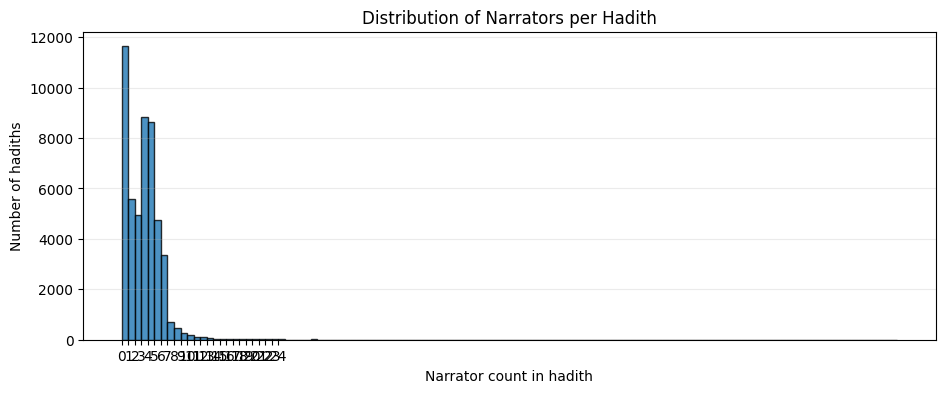

In [3]:
sanad_df['narrators'] = sanad_df[tagged_col].astype(str).apply(extract_narrators)
sanad_df['narrator_count'] = sanad_df['narrators'].apply(len)

all_narrators = [name for names in sanad_df['narrators'] for name in names]
narrator_freq = Counter(all_narrators)

total_mentions = len(all_narrators)
unique_narrators = len(narrator_freq)
print(f'Total narrator mentions: {total_mentions:,}')
print(f'Unique narrators: {unique_narrators:,}')

top50_df = pd.DataFrame(narrator_freq.most_common(50), columns=['narrator', 'frequency'])
print('Top 50 narrators by frequency:')
display(top50_df)

plt.figure(figsize=(11, 4))
max_count = int(sanad_df['narrator_count'].max()) if len(sanad_df) else 0
bins = range(0, max_count + 2)
plt.hist(sanad_df['narrator_count'], bins=bins, edgecolor='black', alpha=0.8)
plt.title('Distribution of Narrators per Hadith')
plt.xlabel('Narrator count in hadith')
plt.ylabel('Number of hadiths')
plt.xticks(range(0, min(max_count + 1, 25)))
plt.grid(axis='y', alpha=0.25)
plt.show()

SUMMARY['total_narrator_mentions'] = int(total_mentions)
SUMMARY['unique_narrators'] = int(unique_narrators)
if narrator_freq:
    top_name, top_freq = narrator_freq.most_common(1)[0]
    SUMMARY['top_narrator'] = top_name
    SUMMARY['top_narrator_frequency'] = int(top_freq)


## C) Analyze `<SANAD>` vs `<MATN>` split

This section computes isnad/matn lengths (word-based), reports coverage of both tags,
and shows sample isnad snippets with narrators highlighted as `[[name]]`.


In [4]:
sanad_df['sanad_text'] = sanad_df[tagged_col].astype(str).apply(lambda x: extract_tag_content(x, SANAD_PATTERN))
sanad_df['matn_text'] = sanad_df[tagged_col].astype(str).apply(lambda x: extract_tag_content(x, MATN_PATTERN))

sanad_df['sanad_words'] = sanad_df['sanad_text'].apply(word_count)
sanad_df['matn_words'] = sanad_df['matn_text'].apply(word_count)

has_sanad = sanad_df['sanad_text'].str.len() > 0
has_matn = sanad_df['matn_text'].str.len() > 0
has_both = has_sanad & has_matn

avg_isnad_words = sanad_df.loc[has_sanad, 'sanad_words'].mean() if has_sanad.any() else 0.0
avg_matn_words = sanad_df.loc[has_matn, 'matn_words'].mean() if has_matn.any() else 0.0
both_count = int(has_both.sum())
pct_both = (has_both.mean() * 100) if len(sanad_df) else 0.0

print(f'Average <SANAD> length (words): {avg_isnad_words:.2f}')
print(f'Average <MATN> length (words): {avg_matn_words:.2f}')
print(f'Rows with both <SANAD> and <MATN>: {both_count:,}/{len(sanad_df):,} ({pct_both:.2f}%)')

sanad_df['sanad_highlighted'] = sanad_df[tagged_col].astype(str).apply(highlight_narrators_in_sanad)
isnad_sample = sanad_df.loc[sanad_df['sanad_highlighted'].str.len() > 0, [id_col, 'sanad_highlighted']]

if isnad_sample.empty:
    print('No <SANAD> sections found for highlighting.')
else:
    print('Sample highlighted sanad snippets (10 rows max):')
    display(isnad_sample.sample(min(10, len(isnad_sample)), random_state=42))

SUMMARY['avg_sanad_words'] = float(avg_isnad_words)
SUMMARY['avg_matn_words'] = float(avg_matn_words)
SUMMARY['pct_with_both_tags'] = float(pct_both)
SUMMARY['both_tags_count'] = int(both_count)


Average <SANAD> length (words): 15.77
Average <MATN> length (words): 53.40
Rows with both <SANAD> and <MATN>: 38,169/50,000 (76.34%)
Sample highlighted sanad snippets (10 rows max):


,row_id,sanad_highlighted
43831,43831,[[مُحَمَّدُ بْنُ عُمَرَ]]
6863,6863,[[الْوَلِيدِ بْنِ زِرْوَانَ]] ، عَنْ [[مَيْمُو...
2982,2982,[[عَبْدُ الرَّحْمَنِ]] ، قَالَ : ثنا [[إِبْرَا...
8974,8974,"[[نَافِعٌ]] , أَنَّ [[ابْنَ عُمَرَ]]"
11292,11292,[[حُمَيْدٌ]] ، عَنْ [[أَبِي الْمُتَوَكِّلِ الن...
10280,10280,[[نَافِعٍ]] مَوْلَي عَبْدِ اللَّهِ ، عَنْ [[اب...
23783,23783,[[شُعْبَةُ]] ، عَنْ [[عَبْدِ الْمَلِكِ بْنِ عُ...
32516,32516,[[ابْنِ عَبَّاسٍ]] [[ابْنِ عَبَّاسٍ]]
43020,43020,[[مُحَمَّدُ بْنُ الصَّبَّاحِ]] ، أَخْبَرَنَا [...
47341,47341,[[مُحَمَّدُ بْنُ عُمَرَ]] ، قَالَ : حَدَّثَنَا...


## D) Quality checks

Checks performed:
- malformed or nested `<NAR>` tags,
- narrators with very long names (>6 words),
- hadiths with zero narrator tags.


In [5]:
flags = sanad_df[tagged_col].astype(str).apply(nar_tag_quality_flags)
sanad_df['nar_malformed'] = flags.apply(lambda x: x[0])
sanad_df['nar_nested'] = flags.apply(lambda x: x[1])

malformed_count = int(sanad_df['nar_malformed'].sum())
nested_count = int(sanad_df['nar_nested'].sum())

print(f'Rows with malformed <NAR> tags: {malformed_count:,}')
print(f'Rows with nested <NAR> tags: {nested_count:,}')

issue_df = sanad_df[sanad_df['nar_malformed'] | sanad_df['nar_nested']].copy()
if not issue_df.empty:
    display(issue_df[[id_col, 'nar_malformed', 'nar_nested', tagged_col]].head(20))

long_narrators = []
for narrator, freq in narrator_freq.items():
    words = word_count(narrator)
    if words > 6:
        long_narrators.append((narrator, words, freq))

long_narrators_df = pd.DataFrame(long_narrators, columns=['narrator', 'word_count', 'frequency'])
if long_narrators_df.empty:
    print('No narrator names with >6 words were found.')
else:
    long_narrators_df = long_narrators_df.sort_values(['frequency', 'word_count'], ascending=False)
    print(f'Narrators with very long names (>6 words): {len(long_narrators_df):,}')
    display(long_narrators_df.head(50))

zero_narr_df = sanad_df[sanad_df['narrator_count'] == 0].copy()
zero_count = len(zero_narr_df)
zero_pct = (zero_count / len(sanad_df) * 100) if len(sanad_df) else 0.0
print(f'Rows with 0 narrators tagged: {zero_count:,} ({zero_pct:.2f}%)')
if not zero_narr_df.empty:
    display(zero_narr_df[[id_col, tagged_col]].head(20))

SUMMARY['malformed_nar_rows'] = malformed_count
SUMMARY['nested_nar_rows'] = nested_count
SUMMARY['long_narrator_names_count'] = int(len(long_narrators_df))
SUMMARY['zero_narrator_rows'] = int(zero_count)
SUMMARY['zero_narrator_pct'] = float(zero_pct)


Rows with malformed <NAR> tags: 0
Rows with nested <NAR> tags: 1,356


,row_id,nar_malformed,nar_nested,Hadith
225,225,False,True,<SANAD> <NAR> <NAR> أَبُو عُبَيْدَةَ </NAR> </...
808,808,False,True,<SANAD> <NAR> الإِمَامُ </NAR> ، عَنْ <NAR> أ...
1116,1116,False,True,أنا أنا <SANAD> <NAR> <NAR> <NAR> عَبْدُ الرَّ...
1125,1125,False,True,أنا <SANAD> <NAR> عَبْدُ الرَّحْمَنِ </NAR> ،...
1176,1176,False,True,أَنْبَأَ أَنْبَأَ <SANAD> <NAR> <NAR> <NAR> عَ...
1249,1249,False,True,أَنْبَأَ <SANAD> <NAR> عَبْدُ الرَّحْمَنِ </NA...
1269,1269,False,True,أَنْبَأَ أَنْبَأَ <SANAD> <NAR> <NAR> عَبْدُ ا...
1373,1373,False,True,أَنْبَأَ <SANAD> <NAR> <NAR> عَبْدُ الرَّحْمَن...
1585,1585,False,True,أنا أنا <SANAD> <NAR> <NAR> عَبْدُ الرَّحْمَنِ...
2169,2169,False,True,أنا أنا <SANAD> <NAR> <NAR> <NAR> عَبْدُ الرَّ...


Narrators with very long names (>6 words): 1,069


,narrator,word_count,frequency
135,عُبَيْدِ اللَّهِ بْنِ عَبْدِ اللَّهِ بْنِ عُتْ...,7,91
166,عَبْدِ اللَّهِ بْنِ أَبِي بَكْرِ بْنِ مُحَمَّد...,11,55
160,عُبَيْدِ اللَّهِ بْنِ عَبْدِ اللَّهِ بْنِ عُتْ...,9,52
238,إِسْحَاقَ بْنِ عَبْدِ اللَّهِ بْنِ أَبِي طَلْحَةَ,7,52
823,أَبُو بَكْرِ بْنُ عَبْدِ اللَّهِ بْنِ أَبِي سَ...,8,47
167,أَبِي سَلَمَةَ بْنِ عَبْدِ الرَّحْمَنِ بْنِ عَ...,7,33
189,أَبِي بَكْرِ بْنِ عَبْدِ الرَّحْمَنِ بْنِ الْح...,9,25
863,أَبُو بَكْرِ بْنُ عَبْدِ اللَّهِ بْنِ أَبِي أُ...,8,21
162,إِسْحَاق بْنِ عَبْدِ اللَّهِ بْنِ أَبِي طَلْحَةَ,7,18
138,أَبِي بَكْرِ بْنِ مُحَمَّدِ بْنِ عَمْرِو بْنِ ...,8,17


Rows with 0 narrators tagged: 11,636 (23.27%)


,row_id,Hadith
1,1,<MATN> وَبِهَذَا السَّنَدِ فِي رِوَايَةٍ أُخْر...
17,17,<MATN> قَالَ : قَالَ : وَكَانَ رَسُولُ اللَّهِ...
20,20,<MATN> وَمِنْ طَرِيقِهِ وَمِنْ طَرِيقِهِ عَنِ ...
84,84,"<MATN> قَالَ : قَالَ : "" وَقَدْ مَرَّ بِرَسُول..."
85,85,<MATN> وَمِنْ طَرِيقِهِ عَنْهُ عَلَيْهِ السَّل...
99,99,<MATN> قَالَ : وَبَلَغَنِي عَنْهُ عَلَيْهِ الس...
131,131,<MATN> قَالَ : وَبَلَغَنِي قَالَ : وَبَلَغَنِي...
288,288,<MATN> وَمِنْ طَرِيقِهِ قَالَ : وَمِنْ طَرِيقِ...
326,326,"<MATN> "" وَنَهَى النَّبِيُّ صَلَّى اللَّهُ عَل..."
328,328,<MATN> وَمِنْ طَرِيقِهِ قَالَ : وَمِنْ طَرِيقِ...


## E) Compare with hadith-json (`bukhari.json`) using fuzzy matching

Process:
- sample 100 random hadiths from `bukhari.json`,
- normalize text and compare against Sanadset hadith text,
- estimate coverage using a fuzzy score threshold.


In [6]:
def extract_hadith_records(payload):
    if isinstance(payload, list):
        return payload
    if not isinstance(payload, dict):
        return []

    candidates = []
    for key in ['hadiths', 'data', 'items', 'results']:
        value = payload.get(key)
        if isinstance(value, list):
            candidates.append(value)
        elif isinstance(value, dict):
            nested = value.get('hadiths')
            if isinstance(nested, list):
                candidates.append(nested)

    if candidates:
        return max(candidates, key=len)
    return []


def extract_hadith_text(record):
    text_keys = ['hadithArabic', 'arabic', 'arab', 'text', 'hadith', 'matn']
    for key in text_keys:
        value = record.get(key)
        if isinstance(value, str) and value.strip():
            return value.strip()

    for value in record.values():
        if isinstance(value, str) and len(value.split()) >= 5:
            return value.strip()
    return ''


def extract_hadith_id(record, fallback):
    id_keys = ['hadithnumber', 'hadithNumber', 'id', 'arabicnumber', 'number']
    for key in id_keys:
        value = record.get(key)
        if isinstance(value, (str, int)):
            return str(value)
    return str(fallback)


if not BUKHARI_PATH.exists():
    print(f'{BUKHARI_PATH} not found. Run `python scripts/download_data.py` and rerun this section.')
else:
    with BUKHARI_PATH.open('r', encoding='utf-8') as handle:
        bukhari_payload = json.load(handle)

    raw_records = extract_hadith_records(bukhari_payload)
    bukhari_rows = []
    for idx, rec in enumerate(raw_records):
        if not isinstance(rec, dict):
            continue
        text = extract_hadith_text(rec)
        if not text:
            continue
        bukhari_rows.append({'bukhari_id': extract_hadith_id(rec, idx), 'text': text})

    bukhari_df = pd.DataFrame(bukhari_rows)
    if bukhari_df.empty:
        print('Could not extract hadith texts from bukhari.json schema.')
    else:
        sample_size = min(100, len(bukhari_df))
        bukhari_sample = bukhari_df.sample(sample_size, random_state=42).reset_index(drop=True)
        print(f'Sampled {sample_size} hadiths from bukhari.json')

        sanad_plain = sanad_df[tagged_col].astype(str).apply(strip_known_tags)
        sanad_norm = sanad_plain.apply(normalize_for_match)
        sanad_lengths = sanad_norm.apply(len)

        token_index = defaultdict(set)
        for i, text in enumerate(sanad_norm):
            tokens = {tok for tok in text.split() if len(tok) >= 4}
            for tok in tokens:
                token_index[tok].add(i)

        def candidate_pool(query_norm):
            tokens = sorted({tok for tok in query_norm.split() if len(tok) >= 4}, key=len, reverse=True)
            candidates = set()
            for tok in tokens[:12]:
                candidates.update(token_index.get(tok, set()))
                if len(candidates) > 4000:
                    break
            return candidates

        threshold = 0.60
        results = []

        for _, row in bukhari_sample.iterrows():
            query_raw = row['text']
            query_norm = normalize_for_match(query_raw)
            if not query_norm:
                continue

            candidates = candidate_pool(query_norm)
            if not candidates:
                continue

            if len(candidates) > 1200:
                candidates = sorted(candidates, key=lambda i: abs(sanad_lengths.iloc[i] - len(query_norm)))[:1200]

            best_idx = None
            best_score = 0.0
            for cand_idx in candidates:
                score = SequenceMatcher(None, query_norm, sanad_norm.iloc[cand_idx]).ratio()
                if score > best_score:
                    best_score = score
                    best_idx = cand_idx

            if best_idx is None:
                continue

            results.append(
                {
                    'bukhari_id': row['bukhari_id'],
                    'score': round(best_score, 4),
                    'matched_sanadset_id': sanad_df.iloc[best_idx][id_col],
                    'bukhari_text_sample': shorten(query_raw),
                    'sanadset_text_sample': shorten(sanad_plain.iloc[best_idx]),
                }
            )

        if not results:
            print('No fuzzy matches were produced. Check text normalization or data availability.')
        else:
            matches_df = pd.DataFrame(results).sort_values('score', ascending=False)
            covered = int((matches_df['score'] >= threshold).sum())
            coverage_pct = (covered / sample_size) * 100 if sample_size else 0.0
            print(f'Coverage at threshold >= {threshold:.2f}: {covered}/{sample_size} ({coverage_pct:.2f}%)')
            display(matches_df.head(25))

            SUMMARY['bukhari_sample_size'] = int(sample_size)
            SUMMARY['bukhari_coverage_threshold'] = float(threshold)
            SUMMARY['bukhari_coverage_count'] = int(covered)
            SUMMARY['bukhari_coverage_pct'] = float(coverage_pct)

print()
print('=' * 84)
print('FINAL SUMMARY - SANADSET EXPLORATION (nrows=50,000)')
print('=' * 84)
print(f"Rows loaded: {SUMMARY['rows_loaded']:,}")
print(f"Detected text column with <NAR>: {SUMMARY['text_column']} (hit rate: {SUMMARY['nar_hit_rate'] * 100:.2f}%)")
print(f"ID column: {SUMMARY['id_column']}")
print('-' * 84)
print(f"Narrator mentions: {SUMMARY['total_narrator_mentions']:,}")
print(f"Unique narrators: {SUMMARY['unique_narrators']:,}")
if SUMMARY['top_narrator']:
    print(f"Top narrator: {SUMMARY['top_narrator']} ({SUMMARY['top_narrator_frequency']:,})")
print('-' * 84)
print(f"Average <SANAD> length (words): {SUMMARY['avg_sanad_words']:.2f}")
print(f"Average <MATN> length (words): {SUMMARY['avg_matn_words']:.2f}")
print(
    f"Rows with both <SANAD> and <MATN>: {SUMMARY['both_tags_count']:,}/{SUMMARY['rows_loaded']:,} "
    f"({SUMMARY['pct_with_both_tags']:.2f}%)"
)
print('-' * 84)
print(f"Malformed <NAR> rows: {SUMMARY['malformed_nar_rows']:,}")
print(f"Nested <NAR> rows: {SUMMARY['nested_nar_rows']:,}")
print(f"Long narrator names (>6 words): {SUMMARY['long_narrator_names_count']:,}")
print(f"Zero-narrator rows: {SUMMARY['zero_narrator_rows']:,} ({SUMMARY['zero_narrator_pct']:.2f}%)")
print('-' * 84)
if SUMMARY['bukhari_sample_size'] > 0:
    print(
        f"Bukhari fuzzy coverage @ >= {SUMMARY['bukhari_coverage_threshold']:.2f}: "
        f"{SUMMARY['bukhari_coverage_count']}/{SUMMARY['bukhari_sample_size']} "
        f"({SUMMARY['bukhari_coverage_pct']:.2f}%)"
    )
else:
    print('Bukhari fuzzy coverage: not computed (missing file or no extracted matches).')
print('=' * 84)


Sampled 100 hadiths from bukhari.json
Coverage at threshold >= 0.60: 20/100 (20.00%)


,bukhari_id,score,matched_sanadset_id,bukhari_text_sample,sanadset_text_sample
17,6030,0.7931,40961,حَدَّثَنَا أَبُو نُعَيْمٍ، حَدَّثَنَا سَيْفٌ، ...,نا الْفَضْلُ بْنُ دُكَيْنٍ ، حَدَّثَنَا سَيْفٌ...
98,1508,0.7794,7730,حَدَّثَنَا عَبْدُ اللَّهِ بْنُ يُوسُفَ، أَخْبَ...,حَدَّثَنِي يَحْيَى ، عَنْ مَالِك ، عَنْ أَبِي ...
34,409,0.7292,37446,حَدَّثَنَا آدَمُ، قَالَ حَدَّثَنَا شُعْبَةُ، ق...,حَدَّثَنَا عُبَيْدُ اللَّهِ بْنُ عُمَرَ ، نا خ...
54,1635,0.7162,7872,حَدَّثَنَا مُسَدَّدٌ، حَدَّثَنَا يَحْيَى، عَنْ...,وَحَدَّثَنِي ، عَنْ مَالِك ، عَنْ نَافِعٍ ، عَ...
21,5503,0.7113,8699,حَدَّثَنِي مُحَمَّدُ بْنُ الْمُثَنَّى، حَدَّثَ...,وَحَدَّثَنِي ، عَنْ مَالِك ، عَنْ هِشَامِ بْنِ...
89,3306,0.6925,5820,حَدَّثَنَا ابْنُ بُكَيْرٍ، حَدَّثَنَا اللَّيْث...,عَنِ الزُّهْرِيِّ ، عَنْ نَافِعٍ ، مَوْلَى أَب...
30,5510,0.6857,24623,حَدَّثَنَا مُوسَى بْنُ إِسْمَاعِيلَ، حَدَّثَنَ...,حَدَّثَنَا حَمَّادُ بْنُ يَزِيدَ ، وَثَابِتٌ أ...
60,6388,0.6825,18972,حَدَّثَنَا مُوسَى، حَدَّثَنَا أَبُو عَوَانَةَ،...,أَخْبَرَنَا ابْنُ عُيَيْنَةَ ، عَنِ الزُّهْرِي...
0,6060,0.6596,30844,حَدَّثَنَا يَحْيَى بْنُ قُزَعَةَ، حَدَّثَنَا إ...,حَدَّثَنَا سُفْيَانُ ، قَالَ : سَمِعْتُ الزُّه...
85,1062,0.6450,11116,حَدَّثَنَا أَبُو نُعَيْمٍ، قَالَ حَدَّثَنَا شَ...,أَخْبَرَنَا أَبُو مُصْعَبٍ ، قَالَ : حَدَّثَنَ...



FINAL SUMMARY - SANADSET EXPLORATION (nrows=50,000)
Rows loaded: 50,000
Detected text column with <NAR>: Hadith (hit rate: 97.77%)
ID column: row_id
------------------------------------------------------------------------------------
Narrator mentions: 143,958
Unique narrators: 16,390
Top narrator: أَبِيهِ (3,967)
------------------------------------------------------------------------------------
Average <SANAD> length (words): 15.77
Average <MATN> length (words): 53.40
Rows with both <SANAD> and <MATN>: 38,169/50,000 (76.34%)
------------------------------------------------------------------------------------
Malformed <NAR> rows: 0
Nested <NAR> rows: 1,356
Long narrator names (>6 words): 1,069
Zero-narrator rows: 11,636 (23.27%)
------------------------------------------------------------------------------------
Bukhari fuzzy coverage @ >= 0.60: 20/100 (20.00%)
